<a href="https://colab.research.google.com/github/Rajrel/Deeplearning_Pytorch/blob/main/cnn_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Convert MNIST image files into a Tensor of 4 dimension (# of images, height,width, color channel)
transform = transforms.ToTensor()

In [4]:
# Train Data
train_data = datasets.MNIST(root = '/cnn_data', train = True, download = True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 19851888.70it/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 633114.49it/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4178629.80it/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3824639.38it/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [5]:
test_data = datasets.MNIST(root = '/cnn_data', train = False, download = True, transform=transform)

In [32]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [33]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [34]:
# Set the batch_size and create loader
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [35]:
# Define our CNN model
# Describe convolutional layer and what its doing
conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, stride = 1)
conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3, stride = 1)


In [14]:
# Take 1 image
for i, (X_Train, y_train) in enumerate(train_data):
    break


In [15]:
X_Train.shape

torch.Size([1, 28, 28])

In [16]:
x = X_Train.view(1,1,28,28)

In [17]:
# perfoprm first convulation
x = F.relu(conv1(x)) # Rectified Linear unit for our activation function

In [19]:
# 1 single image, 6 is the filters, we did not define the padding so it dropped to 26 pixels
x.shape

torch.Size([1, 6, 26, 26])

In [21]:
# Pass through the pooling layer
x = F.max_pool2d(x, 2, 2)# kernel of 2 and stride of 2

In [23]:
x.shape # 26/2 = 13

torch.Size([1, 6, 13, 13])

In [24]:
# Second convolutional layer
x = F.relu(conv2(x))

In [25]:
x.shape # 16 becoz of second layer as 16, no padding so 11

torch.Size([1, 16, 11, 11])

In [26]:
# Pooling layer
x = F.max_pool2d(x, 2, 2)

In [27]:
x.shape

torch.Size([1, 16, 5, 5])

In [48]:
# Model Class
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)

        # Fully connected layer
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2) # 2X2 kernal and stride 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Review to flatten the data
        x = x.view(-1, 16*5*5) # negative one so that we can vary the batch size
        # Fully Conntect Layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)


In [49]:
# Create an instance of our Model
torch.manual_seed(81)
model = CNNModel()
model

CNNModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [50]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # smaller the learning rate, longer its gonna take to train

In [52]:
import time
start_time = time.time()
# Create Variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1 # Start the batches at 1
        # Apply the model
        y_pred = model(X_train) # Get the predicted value - not flattened D
        loss = criterion(y_pred, y_train) # compare predictions to correct labels
        predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions
        batch_corr = (predicted == y_train).sum() # how many we got correct from this batch
        trn_corr += batch_corr #Keep track as we go along in training
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%600 == 0:
            print(f'epoch: {i} batch: {b} loss: {loss.item()}')
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test
    with torch.no_grad(): # No gradint so we donot update our weights and biases
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1] # adding up correct predictions
            tst_corr += (predicted == y_test).sum()
        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)



current_time = time.time()
total = current_time-start_time
print(f'Total time: {total/60} minutes')

epoch: 0 batch: 600 loss: 0.17548519372940063
epoch: 0 batch: 1200 loss: 0.26744264364242554
epoch: 0 batch: 1800 loss: 0.007082493044435978
epoch: 0 batch: 2400 loss: 0.20806293189525604
epoch: 0 batch: 3000 loss: 0.016682909801602364
epoch: 0 batch: 3600 loss: 0.054833002388477325
epoch: 0 batch: 4200 loss: 0.021794412285089493
epoch: 0 batch: 4800 loss: 0.008827694691717625
epoch: 0 batch: 5400 loss: 0.010525593534111977
epoch: 0 batch: 6000 loss: 0.06951300799846649
epoch: 1 batch: 600 loss: 0.1018005758523941
epoch: 1 batch: 1200 loss: 1.5885639190673828
epoch: 1 batch: 1800 loss: 0.22876933217048645
epoch: 1 batch: 2400 loss: 0.025363732129335403
epoch: 1 batch: 3000 loss: 0.30134326219558716
epoch: 1 batch: 3600 loss: 0.2699052691459656
epoch: 1 batch: 4200 loss: 0.14493343234062195
epoch: 1 batch: 4800 loss: 0.09168615937232971
epoch: 1 batch: 5400 loss: 0.13209156692028046
epoch: 1 batch: 6000 loss: 0.1980893760919571
epoch: 2 batch: 600 loss: 0.24776677787303925
epoch: 2 batc

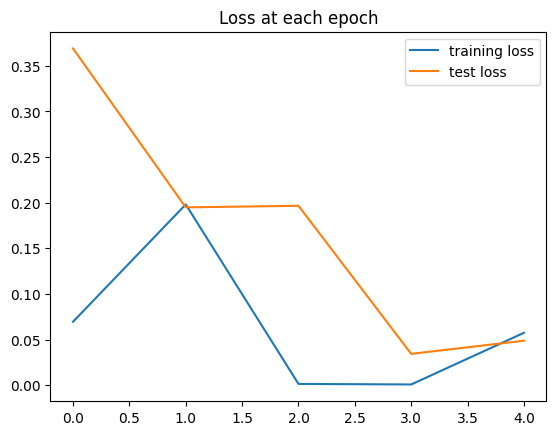

In [54]:
# Graph loss at each epoch

train_losses = [t.item() for t in train_losses]
test_losses = [t.item() for t in test_losses]
plt.plot(train_losses, label = 'training loss')
plt.plot(test_losses, label = 'test loss')
plt.title('Loss at each epoch')
plt.legend()

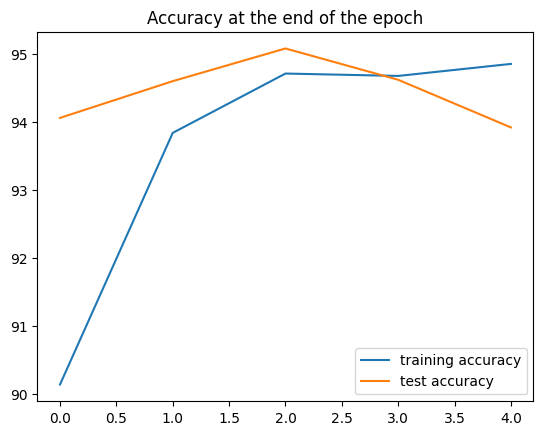

In [56]:
# Graph the accuracy at the end of the epoch
plt.plot([t/600 for t in train_correct], label = 'training accuracy')
plt.plot([t/100 for t in test_correct], label = 'test accuracy')
plt.title('Accuracy at the end of the epoch')
plt.legend()

In [57]:
test_load_everything = DataLoader(test_data,batch_size = 10000, shuffle = False)
with torch.no_grad():
    correct = 0
    for x_test, y_test in test_load_everything:
        y_val = model(x_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum()

print(f'Test accuracy: {correct/len(test_data)}')

Test accuracy: 0.9391999840736389


In [58]:
correct.item()

9392